Variational AutoEncoder structure to fill some time series sequences that can be characterized by the presence of missing data in a real scenario. In the second stage, we also inspect the results produced by our trained VAE to investigate the possibility to produce augmented time-series samples.

Since the full history of traffic at our disposal is considerable but with some missing intervals, we decide to focus on the last 3 years of data. This is because the mentioned period seems to be consistent enough due to the rare presence of missing pieces that, in case, can be filled with simple interpolations to have a complete and valuable data source to develop our approach.

# explain

Given a selected time interval of meaningful data, we force the introduction of some missing intervals (with a fixed length and proportion) in the data stream

The missing sequences form the main input for our Variational AutoEncoder that is trained to approximate the true sequences without missing pieces.

we start from a complete data source, on which we insert random missing intervals because this enables us to make a comparison with the true reality and compute performance metrics.

The second meaningful inputs of the VAE are sequences of integers that encode the additional information present as categorical features, i.e. month, weekday, hour, holiday, weather conditions

In correspondence with missing values in the raw traffic signals, we take care to substitute the corresponding categories with a special integer (let’s say 0) to encode properly the status of ‘missing information’ (this is not valid for the month, weekday, hour which are known always for every date).

The encoder consists of an LSTM cell. It receives as input 3D sequences resulting from the concatenation of the raw traffic data and the embeddings of categorical features. As in every encoder in a VAE architecture, it produces a 2D output that is used to approximate the mean and the variance of the latent distribution. The decoder samples from the 2D latent distribution upsampling to form 3D sequences. The generated sequences are then concatenated back with the original categorical embeddings which are passed through an LSTM cell to reconstruct the original traffic sequences.

The training of a VAE is made minimizing a loss which is the combination of two pieces. A reconstruction part (scaled mean squared error in our case), that says how much the model can reproduce the target, and a regularization part (Kullback Leibler divergence), which acts as a constraint to make the latent space more similar to a normal distribution.

# RESULTS AND APPLICATIONS

The main purpose of our approach is to develop an unsupervised framework that can fill the missing pieces that appear in the traffic volume stream. 

To test the goodness of this task we reserve part of our data to compute performance metrics, like the classical MSE/RMSE to verify the reconstruction ability. We can also compute specific statistics only on the missing pieces subject to reconstruction. The test set is obtained with a simple temporal split on the last part of the dataset. This part is roughly composed of the same proportion of missing sequences as in the whole dataset.

A second possible application of our trained model consists of using it to generate new sequences.

This is a common behavior of all the VAE where the encoder and the decoder can be utilized separately to create new samples. The encoder projects the inputs in a specific region of the latent space. We use the coordinates of the projections to sample new points nearby. The ‘vicinity’ can be regulated by selecting a desired amount of variance. The latent points are passed through the decoder to operate the sequence generations. Obviously, the closer are the points more similar are the final reconstructions. Important to notice also that the goodness of the sample generation is strictly related to the reconstruction ability of the entire VAE.
Image for post.

# Library

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar_time_series import time_series
from ursar import describe, deep_learning
%reload_ext autoreload

# read data

In [3]:
df = pd.read_csv(r'E:\gitlab\dataset\time_series\Metro_Interstate_Traffic_Volume.csv.gz')
df['date_time'] = pd.to_datetime(df['date_time'])
df.drop_duplicates('date_time', inplace=True)
df.set_index('date_time', inplace=True)

print(df.shape)
df.head()

(40575, 8)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


# INSERT MISSING DATES

In [4]:
df = df.reindex(pd.date_range(df.head(1).index[0], df.tail(1).index[0], freq='H'))

df.shape

(52551, 8)

# PLOT TRAFFIC SAMPLE

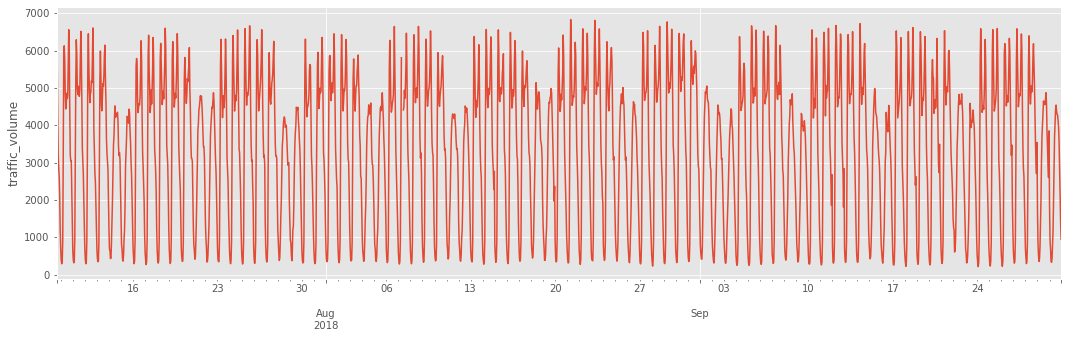

In [5]:
df.traffic_volume.tail(2000).plot(figsize=(18,5))
plt.ylabel('traffic_volume')
plt.show()

# PLOT MISSING VALUES OVER TIME

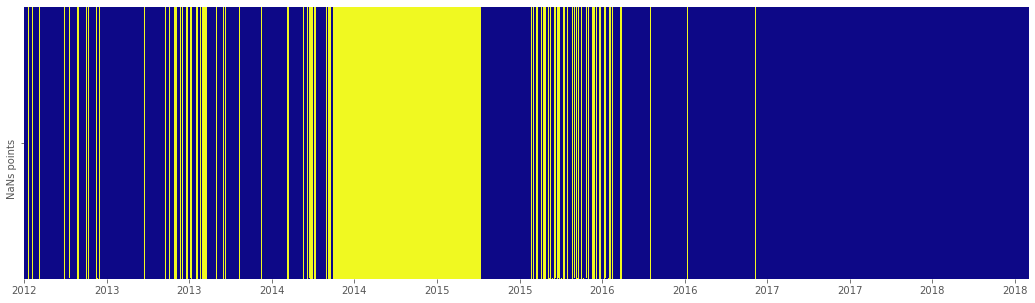

In [6]:
time_series.heatmap_missing(df,col=["traffic_volume"])

# FILL MISSING VALUES

In [7]:
df = df[df.index.year.isin([2016,2017,2018])].copy()

df = pd.concat([df.select_dtypes(include=['object']).fillna(method='backfill'),
                df.select_dtypes(include=['float']).interpolate()], axis=1)

df.shape

(24096, 8)

# PLOT TRAFFIC DISTRIBUTION IN EACH MONTH

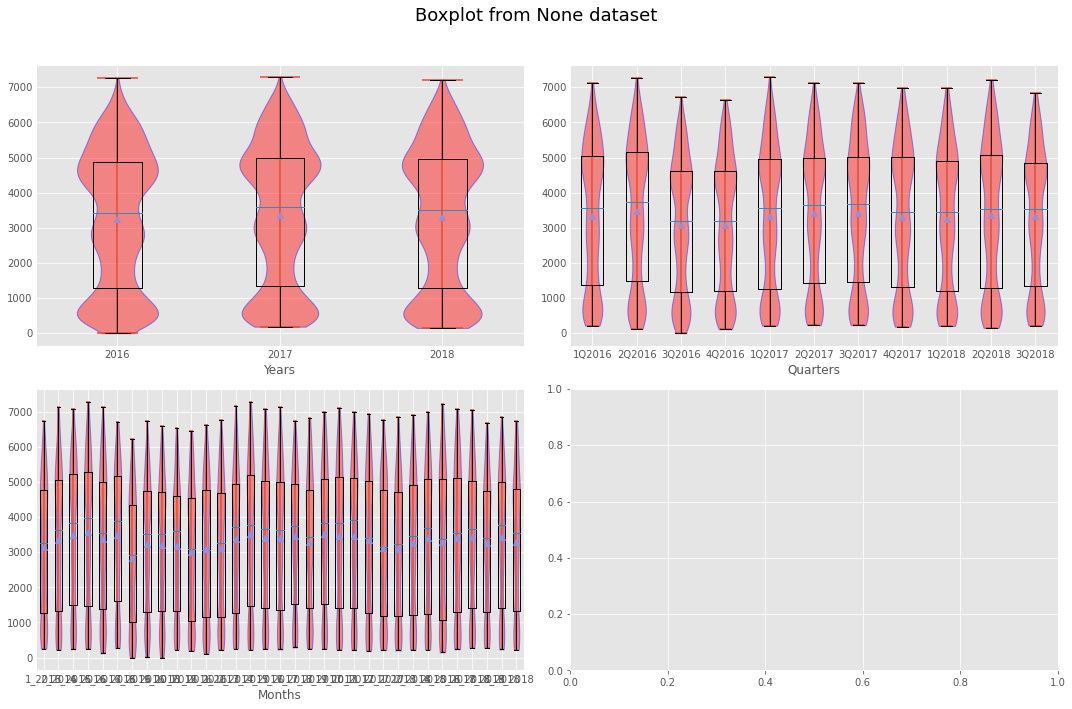

In [8]:
time_series.box_plot(df,"traffic_volume",time_list=['Y','Q','M'],row_col=(2,2),notation=False)

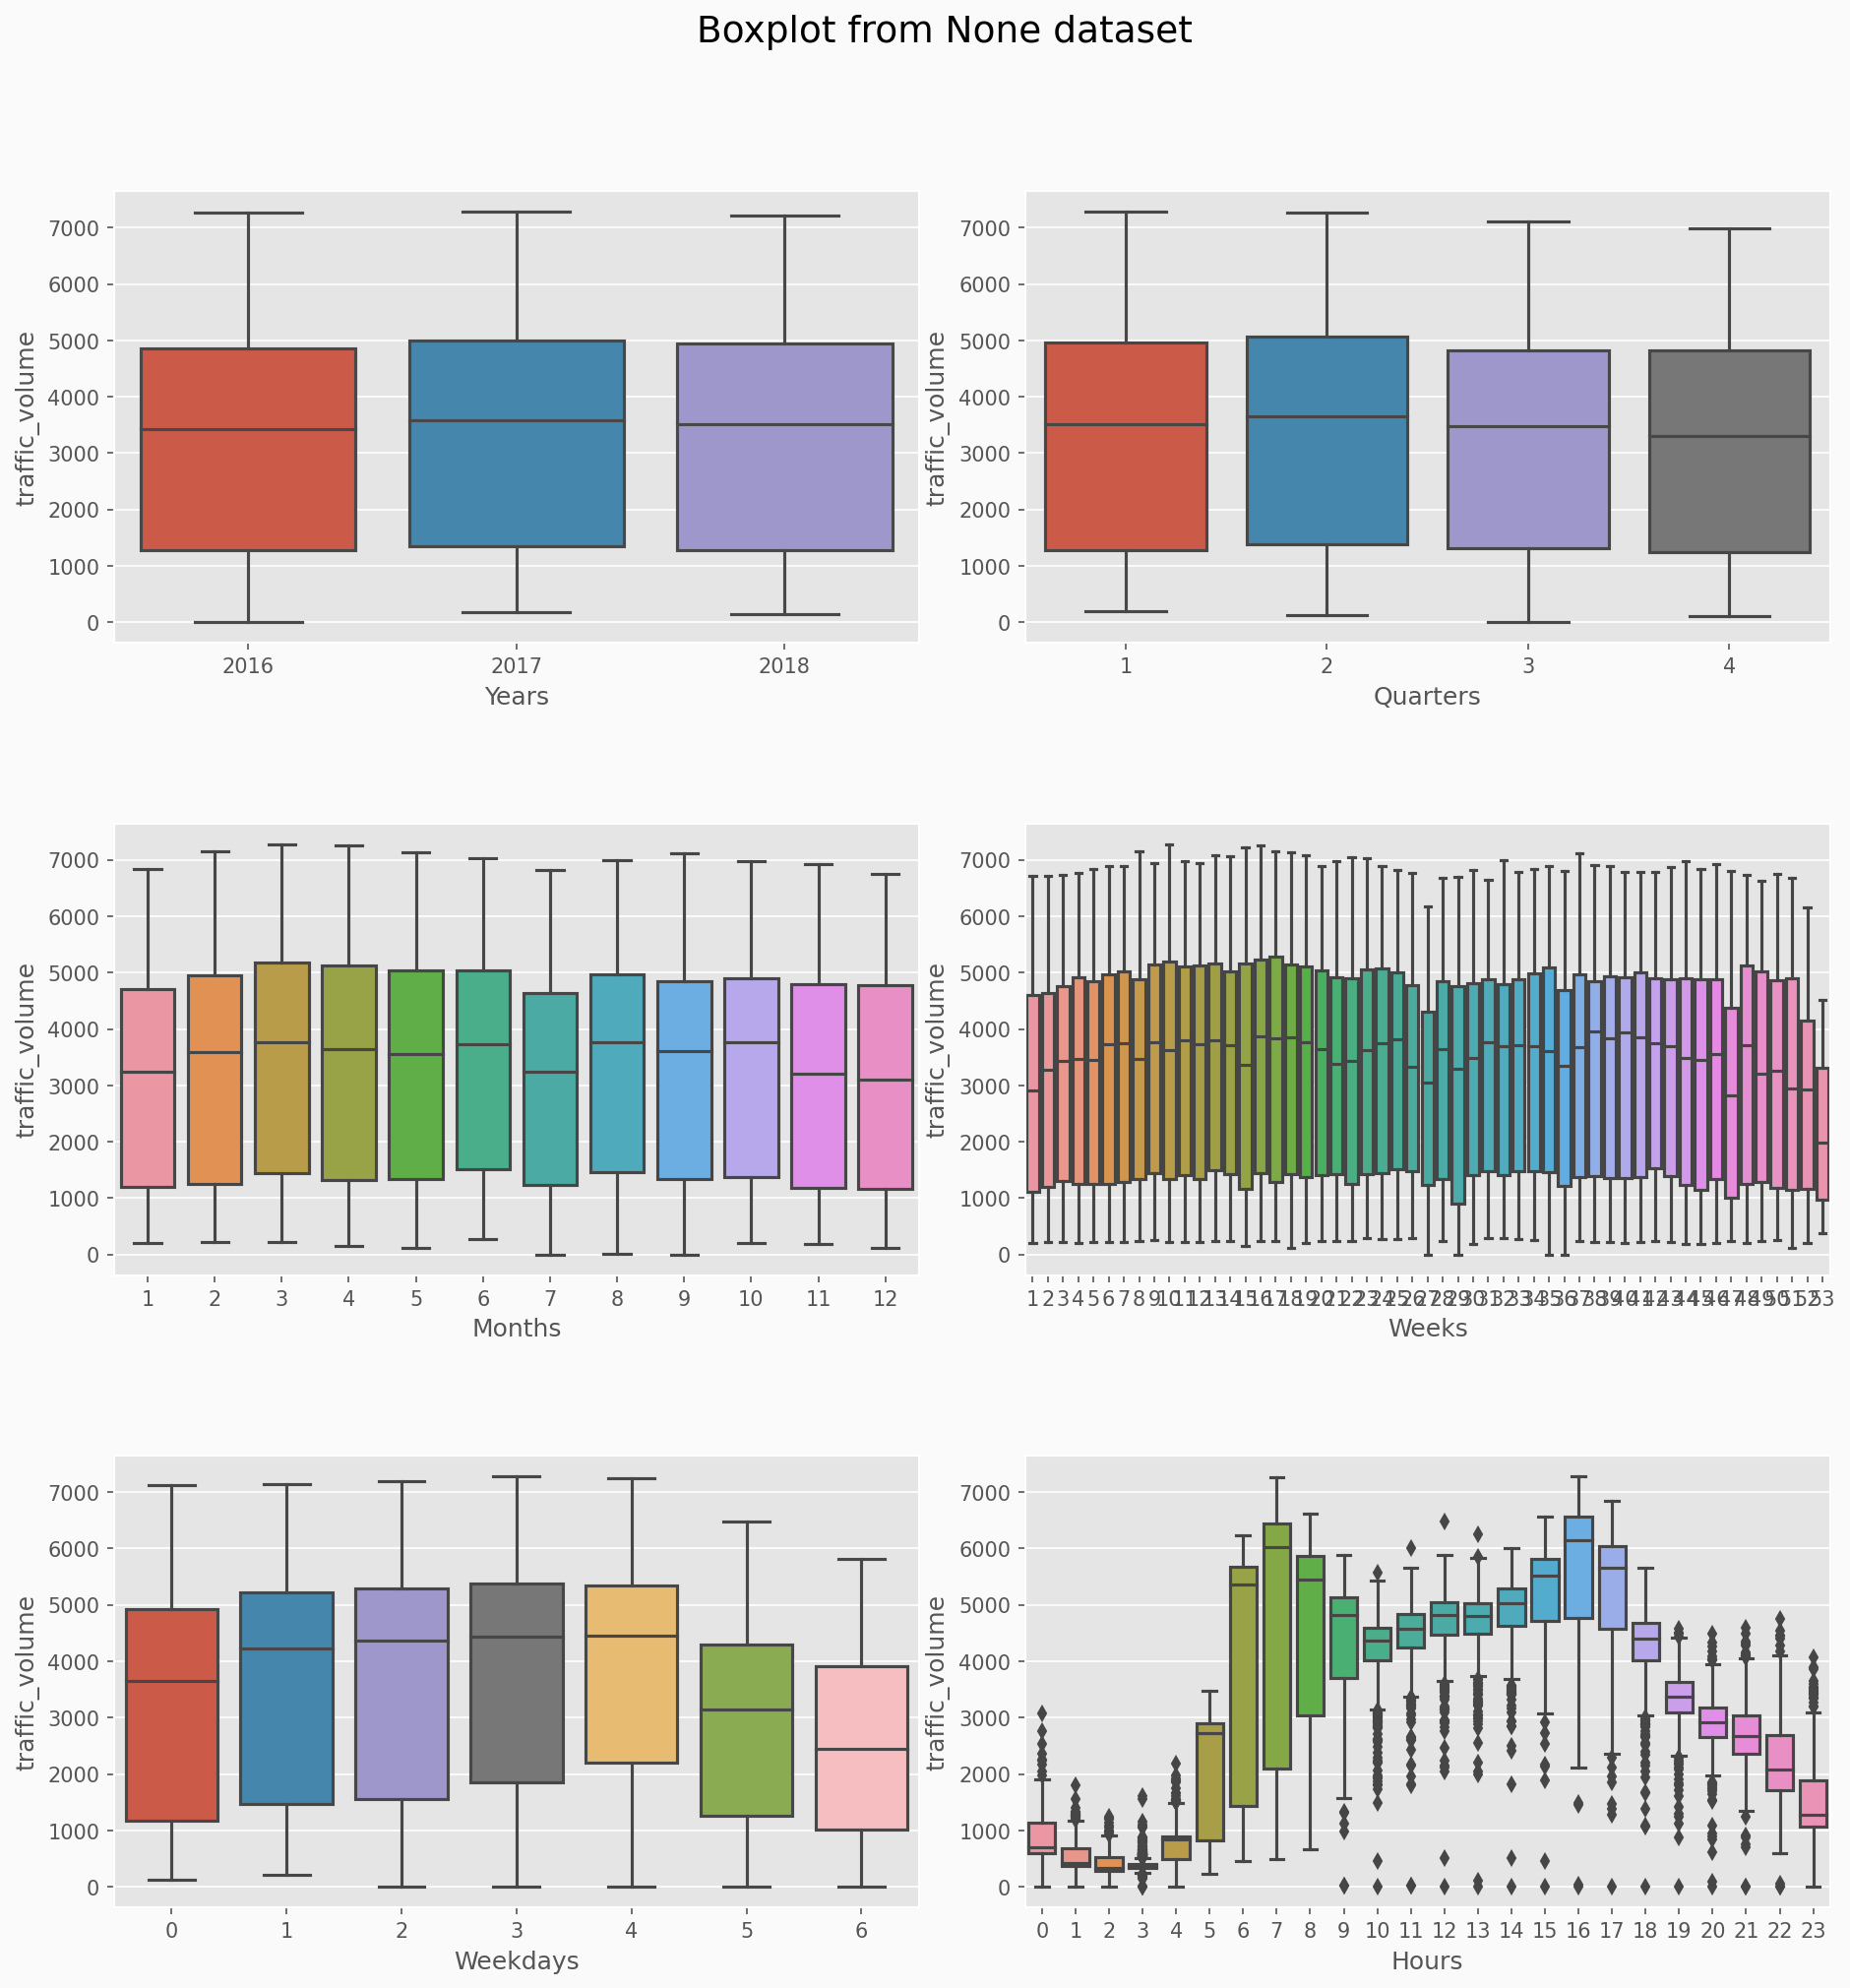

In [9]:
time_series.box_collect_plot(df,"traffic_volume",time_list=['Y','Q','M','W','WD','H'], row_col=(3,2))

# NUMERICAL ENCODE CATEGORICAL COLUMNS

get all numeric feature and add month,weekday, hour

In [10]:
map_col = dict()

X = df.select_dtypes(include=['object']).copy()
for i,cat in enumerate(X):
    X[cat] = df[cat].factorize()[0]
    map_col[cat] = i

X['month'] = df.index.month;  i += 1;  map_col['month'] = i
X['weekday'] = df.index.weekday;  i += 1;  map_col['weekday'] = i
X['hour'] = df.index.hour;  i += 1;  map_col['hour'] = i
X.shape

(24096, 6)

In [11]:
df[["holiday","weather_main","weather_description"]]=X[["holiday","weather_main","weather_description"]]
df = df[["holiday","weather_main","weather_description",'traffic_volume']]
df["month"] = X["month"]
df["weekday"] = X["weekday"]
df["hour"] = X["hour"]

In [12]:
df

,holiday,weather_main,weather_description,traffic_volume,month,weekday,hour
2016-01-01 00:00:00,0,0,0,1513.0,1,4,0
2016-01-01 01:00:00,1,1,1,1550.0,1,4,1
2016-01-01 02:00:00,1,1,1,1134.5,1,4,2
2016-01-01 03:00:00,1,1,1,719.0,1,4,3
2016-01-01 04:00:00,1,2,2,533.0,1,4,4
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,1,2,4,3543.0,9,6,19
2018-09-30 20:00:00,1,2,2,2781.0,9,6,20
2018-09-30 21:00:00,1,8,16,2159.0,9,6,21
2018-09-30 22:00:00,1,2,2,1450.0,9,6,22


# UTILITY FUNCTION FOR 3D SEQUENCE GENERATION AND GENERATE 3D SEQUENCES

In [13]:
def gen_seq(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))

In [14]:
sequence_input,sequence_target = time_series.sequence_generator(df,
                                                    target='traffic_volume',
                                                    sequence_length = 24*7)

In [15]:
sequence_input.shape

(23928, 168, 6)

In [16]:
sequence_target.shape

(23928, 168, 1)

# UTILITY FUNCTION TO INSERT RANDOM MISSING INTERVALS

In [17]:
sequence_length = 24*7

sequence_input = []
sequence_target = []

for seq in gen_seq(X, sequence_length, X.columns):
    sequence_input.append(seq)
    
for seq in gen_seq(df, sequence_length, ['traffic_volume']):
    sequence_target.append(seq)
    
sequence_input = np.asarray(sequence_input)
sequence_target = np.asarray(sequence_target)

sequence_input.shape, sequence_target.shape

((23928, 168, 6), (23928, 168, 1))

In [18]:
def drop_fill_pieces(sequence_input, sequence_target, missing_len, missing_val=np.nan, size=0.2):
    
    sequence_input = np.copy(sequence_input)
    sequence_target = np.copy(sequence_target)
    
    _id_seq = np.random.choice(range(len(sequence_target)), int(len(sequence_target)*size), replace=False)
    _id_time = np.random.randint(0,sequence_length-missing_len, int(len(sequence_target)*size))
    
    for i,t in zip(_id_seq, _id_time):
        sequence_input[i, t:t+missing_len, 
                       [map_col['holiday'], 
                        map_col['weather_main'],
                        map_col['weather_description']]] = -1
        sequence_target[i, t:t+missing_len, :] = missing_val
        
    sequence_input[:,:, 
                   [map_col['holiday'], 
                    map_col['weather_main'],
                    map_col['weather_description']]] += 1
    
    return sequence_input, sequence_target

# INSERT MISSING INTERVALS AT RANDOM 

In [19]:
np.random.seed(33)

missing_len = 24
sequence_input, sequence_target_drop = drop_fill_pieces(sequence_input, sequence_target,
                                                        missing_len=missing_len, size=0.6)

sequence_input.shape, sequence_target_drop.shape

((23928, 168, 6), (23928, 168, 1))

# TRAIN TEST SPLIT

In [20]:
train_size = 0.8

sequence_input_train = sequence_input[:int(len(sequence_input)*train_size)]
sequence_input_test = sequence_input[int(len(sequence_input)*train_size):]
print(sequence_input_train.shape, sequence_input_test.shape)

sequence_target_train = sequence_target[:int(len(sequence_target)*train_size)]
sequence_target_test = sequence_target[int(len(sequence_target)*train_size):]
print(sequence_target_train.shape, sequence_target_test.shape)

sequence_target_drop_train = sequence_target_drop[:int(len(sequence_target_drop)*train_size)]
sequence_target_drop_test = sequence_target_drop[int(len(sequence_target_drop)*train_size):]
print(sequence_target_drop_train.shape, sequence_target_drop_test.shape)

(19142, 168, 6) (4786, 168, 6)
(19142, 168, 1) (4786, 168, 1)
(19142, 168, 1) (4786, 168, 1)


# UTILITY CLASS FOR SEQUENCES SCALING

In [21]:
class Scaler1D:
    
    def fit(self, X):
        self.mean = np.nanmean(np.asarray(X).ravel())
        self.std = np.nanstd(np.asarray(X).ravel())
        return self
        
    def transform(self, X):
        return (X - self.mean)/self.std
    
    def inverse_transform(self, X):
        return (X*self.std) + self.mean

# SCALE SEQUENCES AND MASK NANs

In [22]:
scaler_target = Scaler1D().fit(sequence_target_train)

sequence_target_train = scaler_target.transform(sequence_target_train)
sequence_target_test = scaler_target.transform(sequence_target_test)

sequence_target_drop_train = scaler_target.transform(sequence_target_drop_train)
sequence_target_drop_test = scaler_target.transform(sequence_target_drop_test)

mask_value = -999.
sequence_target_drop_train[np.isnan(sequence_target_drop_train)] = mask_value
sequence_target_drop_test[np.isnan(sequence_target_drop_test)] = mask_value

# UTILITY FUNCTIONS FOR VAE CREATION

In [25]:
vae, enc, dec = time_series.get_model(main_data=X,
                                  sequence_length = 168,
                                  latent_dim = 2,
                                  col_cat=['holiday', 'weather_main', 'weather_description'])

In [28]:
es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, 
                   monitor='val_loss', mode='auto', restore_best_weights=True)

# running model 

In [29]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 168)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 168)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 168)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 168)]        0           []                               
                                                                                            

In [ ]:
# tf.random.set_seed(33)
# os.environ['PYTHONHASHSEED'] = str(33)
# np.random.seed(33)
# random.seed(33)

In [30]:
history = vae.fit([sequence_input_train[:,:,i] for cat,i in X.columns] + [sequence_target_drop_train, sequence_target_train], 
                    batch_size=128, epochs=100, 
                    validation_split=0.2, 
                    shuffle=False, callbacks=[es])

Epoch 1/100
120/120 [==============================] - 17s 94ms/step - loss: 83.3757 - val_loss: 39.2296
Epoch 2/100
120/120 [==============================] - 11s 88ms/step - loss: 23.0808 - val_loss: 22.3010
Epoch 3/100
120/120 [==============================] - 11s 88ms/step - loss: 15.6825 - val_loss: 18.9648
Epoch 4/100
120/120 [==============================] - 10s 86ms/step - loss: 13.2401 - val_loss: 22.8519
Epoch 5/100
120/120 [==============================] - 10s 87ms/step - loss: 12.0270 - val_loss: 24.8989
Epoch 6/100
120/120 [==============================] - 10s 85ms/step - loss: 11.4157 - val_loss: 22.0711
Epoch 7/100
120/120 [==============================] - 10s 85ms/step - loss: 10.8877 - val_loss: 19.1339
Epoch 8/100
120/120 [==============================] - 10s 87ms/step - loss: 10.6807 - val_loss: 17.9245
Epoch 9/100
120/120 [==============================] - 10s 86ms/step - loss: 10.9587 - val_loss: 20.2609
Epoch 10/100
120/120 [==============================] -

# COMPUTE RECONSTRUCTION

In [33]:
vae = Model(vae.input[:-1], vae.output)

reconstruc_train = scaler_target.inverse_transform(
    vae.predict([sequence_input_train[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_train]))
reconstruc_test = scaler_target.inverse_transform(
    vae.predict([sequence_input_test[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_test]))

reconstruc_train.shape, reconstruc_test.shape

((19142, 168, 1), (4786, 168, 1))

# PLOT REAL vs RECONSTRUCTION

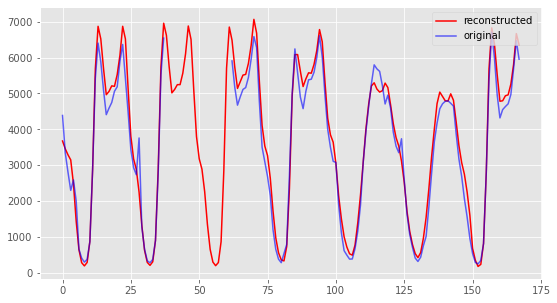

In [34]:
id_seq = 100

seq = np.copy(sequence_target_drop_test[id_seq])
seq[seq == mask_value] = np.nan
seq = scaler_target.inverse_transform(seq)

plt.figure(figsize=(9,5))
plt.plot(reconstruc_test[id_seq], label='reconstructed', c='red')
plt.plot(seq, c='blue', label='original', alpha=0.6)
plt.legend()

# PLOT REAL vs RECONSTRUCTION

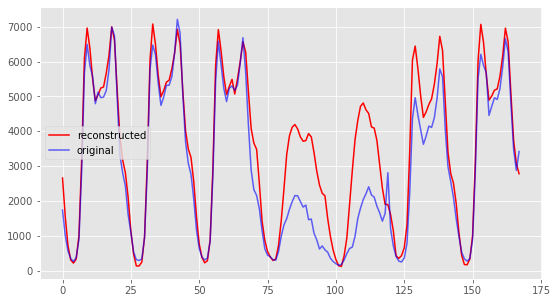

In [35]:
id_seq = 800

seq = np.copy(sequence_target_drop_test[id_seq])
seq[seq == mask_value] = np.nan
seq = scaler_target.inverse_transform(seq)

plt.figure(figsize=(9,5))
plt.plot(reconstruc_test[id_seq], label='reconstructed', c='red')
plt.plot(seq, c='blue', label='original', alpha=0.6)
plt.legend()

# COMPUTE PERFORMANCES ON TRAIN

In [36]:
mask = (sequence_target_drop_train == mask_value)

print('reconstruction error on entire sequences:',
    mse(np.squeeze(reconstruc_train, -1), np.squeeze(sequence_target_train, -1), squared=False))
print('reconstruction error on missing sequences:',
    mse(reconstruc_train[mask].reshape(-1,missing_len), sequence_target_train[mask].reshape(-1,missing_len), squared=False))

reconstruction error on entire sequences: 4054.710572374092
reconstruction error on missing sequences: 4053.595695620276


# COMPUTE PERFORMANCES ON TEST

In [37]:
mask = (sequence_target_drop_test == mask_value)

print('reconstruction error on entire sequences:',
    mse(np.squeeze(reconstruc_test, -1), np.squeeze(sequence_target_test, -1), squared=False))
print('reconstruction error on missing sequences:',
    mse(reconstruc_test[mask].reshape(-1,missing_len), sequence_target_test[mask].reshape(-1,missing_len), squared=False))

reconstruction error on entire sequences: 4069.607422755977
reconstruction error on missing sequences: 4074.271303971753


# GET LATENT REPRESENTATION ON TRAIN DATA

In [38]:
enc_pred, _ = enc.predict([sequence_input_train[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_train])
enc_pred.shape

(19142, 2)

# PLOT LATENT REPRESENTATION

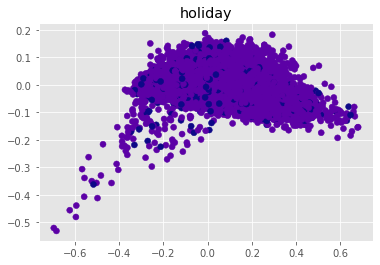

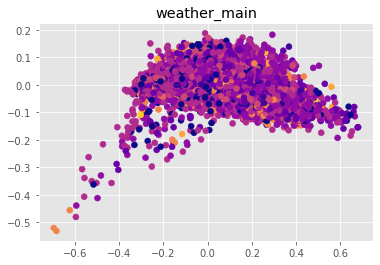

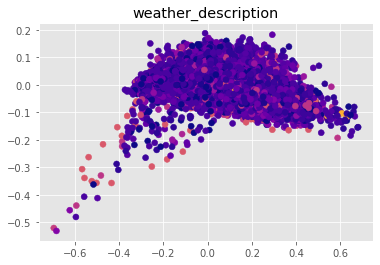

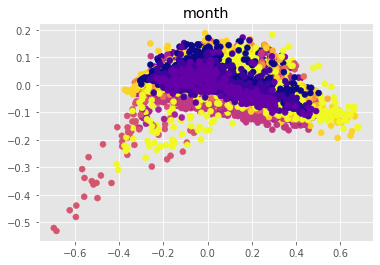

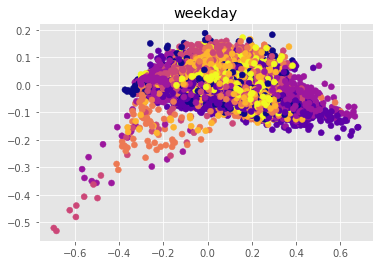

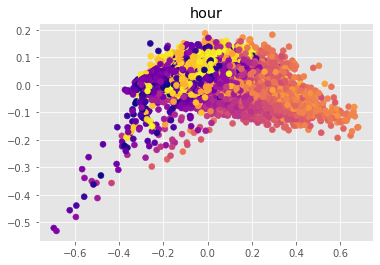

In [39]:
for cat,i in map_col.items():
    plt.scatter(enc_pred[:,0], enc_pred[:,1], c=sequence_input_train[:,sequence_length//2,i], cmap='plasma')
    plt.title(cat); plt.show()

# GENERATE RANDOM PERMUTATION

In [40]:
np.random.seed(33)

id_seq = 3333

_X = np.random.normal(enc_pred[id_seq,0], 3, 10)
_Y = np.random.normal(enc_pred[id_seq,1], 3, 10)
_cat_input = [sequence_input_train[[id_seq],:,i] for cat,i in map_col.items()]

# PLOT RANDOM PERMUTATION

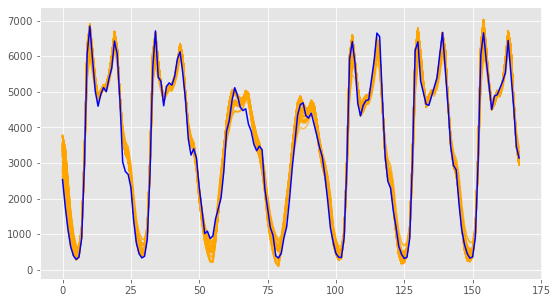

In [41]:
plt.figure(figsize=(9,5))
        
for x in _X:
    for y in _Y:
        dec_pred = dec.predict([np.asarray([[x,y]])] + _cat_input)
        plt.plot(scaler_target.inverse_transform(dec_pred[0]), c='orange', alpha=0.6)
plt.plot(scaler_target.inverse_transform(sequence_target_train[id_seq]), c='blue')